In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import  KerasRegressor
from sklearn.model_selection import GridSearchCV


df=pd.read_csv("ETTh1.csv",infer_datetime_format=True,index_col='date')
df.shape

C:\Users\12204\AppData\Local\Temp\ipykernel_10004\803008069.py:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv("ETTh1.csv",infer_datetime_format=True,index_col='date')


(17420, 7)

In [7]:
# def plot_features(dataset):
#     plt.figure(figsize=(16,12), dpi=200)
#     for i in range(len(dataset.columns)):
#         plt.subplot(len(dataset.columns), 1, i+1)
#         feature_name = dataset.columns[i]
#         plt.plot(dataset[feature_name])
#         plt.title(feature_name, y=0)
#         plt.grid(linestyle='--', alpha=0.5)
    
#     plt.tight_layout()
#     plt.show()
    
# plot_features(df)


In [98]:
# 切分数据集 6:2:2
total_samples = df.shape[0]
train_split = int(0.6 * total_samples)
val_split = int(0.2 * total_samples)

# 切割数据集
train_data = df[:train_split]
val_data = df[train_split:train_split + val_split]
test_data = df[train_split + val_split:]

# 检查切割后的数据集形状
print("训练集形状:", train_data.shape)
print("验证集形状:", val_data.shape)
print("测试集形状:", test_data.shape)


训练集形状: (10452, 7)
验证集形状: (3484, 7)
测试集形状: (3484, 7)


In [101]:
#制作滑动窗口
# 形成训练数据，例如12345789 12-3、23-4、34-5
def split_data(data, timestep):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep*2):
        dataX.append(data[index: index + timestep][:])
        dataY.append(data[index + timestep][:])      # 全部的数据训练！！！

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    return [dataX,dataY]



In [102]:
train_X,train_Y = split_data(train_data,timestep=96)
# val_X,val_Y = split_data(val_data,96)
# test_X,test_Y = split_data(test_data,96)                   #数据集制作OK
# test_X


KeyError: 96

In [76]:
train_X[96:192].shape
train_Y[:96].shape
train_X[96:192] == train_Y[:96]




array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [11]:
# 数据归一化    ------------------------   可以尝试一下更多的归一化！！

import copy
from sklearn.preprocessing import MinMaxScaler


def scalerr(rawdata):
    scalers = []
    scalered_data = copy.deepcopy(rawdata)
    for dim in range(rawdata.shape[2]):
        scaler = MinMaxScaler()
        scalered_data[:, :, dim] = scaler.fit_transform(scalered_data[:, :, dim])
        scalers.append(scaler)     

    return[scalered_data,scalers]     

train_X_sc,train_X_scalers = scalerr(train_X)
train_Y_sc,train_Y_scalers = scalerr(train_Y)
val_X_sc,train_X_scalers = scalerr(val_X)
val_Y_sc,train_Y_scalers = scalerr(val_Y)
test_X_sc,test_X_scalers = scalerr(test_X)
test_Y_sc,test_Y_scalers = scalerr(test_Y)

In [79]:
# 模型
def build_my_model():
    md = Sequential()
    md.add(LSTM(50,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
    md.add(LSTM(50))
    md.add(Dropout(0.2))
    md.add(Dense(train_X.shape[2]))
    
    md.compile(loss="mae",optimizer='adam')
    return md

In [81]:
md = build_my_model()
hst = md.fit(train_X[:-84],train_Y[:-84],batch_size=96,epochs=10)

Epoch 1/10
106/106 [==============================] - 6s 37ms/step - loss: 4.0520
Epoch 2/10
106/106 [==============================] - 4s 38ms/step - loss: 3.0483
Epoch 3/10
106/106 [==============================] - 4s 37ms/step - loss: 2.8898
Epoch 4/10
106/106 [==============================] - 4s 37ms/step - loss: 2.8525
Epoch 5/10
106/106 [==============================] - 5s 45ms/step - loss: 2.8396
Epoch 6/10
106/106 [==============================] - 4s 40ms/step - loss: 2.8313
Epoch 7/10
106/106 [==============================] - 4s 41ms/step - loss: 2.8248
Epoch 8/10
106/106 [==============================] - 4s 38ms/step - loss: 2.8219
Epoch 9/10
106/106 [==============================] - 4s 38ms/step - loss: 2.8197
Epoch 10/10
106/106 [==============================] - 4s 38ms/step - loss: 2.8178


In [89]:
prd = md.predict(test_X[:96])

3/3 [==============================] - 0s 10ms/step


In [90]:
prd


array([[ 8.362513  ,  1.6642992 ,  5.7705827 ,  0.5902598 ,  2.7782464 ,
         0.9010686 , 16.099716  ],
       [ 8.460256  ,  1.6802776 ,  5.8422666 ,  0.5877806 ,  2.8038497 ,
         0.90990305, 16.22274   ],
       [ 8.486558  ,  1.6856472 ,  5.8568983 ,  0.58091235,  2.809546  ,
         0.912502  , 16.253569  ],
       [ 8.479013  ,  1.6834009 ,  5.851483  ,  0.58079195,  2.80509   ,
         0.9123294 , 16.247206  ],
       [ 8.465049  ,  1.6842487 ,  5.8438954 ,  0.5787939 ,  2.8018255 ,
         0.91134113, 16.231966  ],
       [ 8.456553  ,  1.6807489 ,  5.8368826 ,  0.5759945 ,  2.8006535 ,
         0.9105789 , 16.21718   ],
       [ 8.455096  ,  1.6779313 ,  5.83418   ,  0.5754335 ,  2.8005111 ,
         0.91037256, 16.211945  ],
       [ 8.453929  ,  1.674293  ,  5.830532  ,  0.5747133 ,  2.8003988 ,
         0.91022176, 16.20682   ],
       [ 8.4522295 ,  1.6718862 ,  5.824388  ,  0.5742811 ,  2.80063   ,
         0.9098417 , 16.198116  ],
       [ 8.453496  ,  1.6691

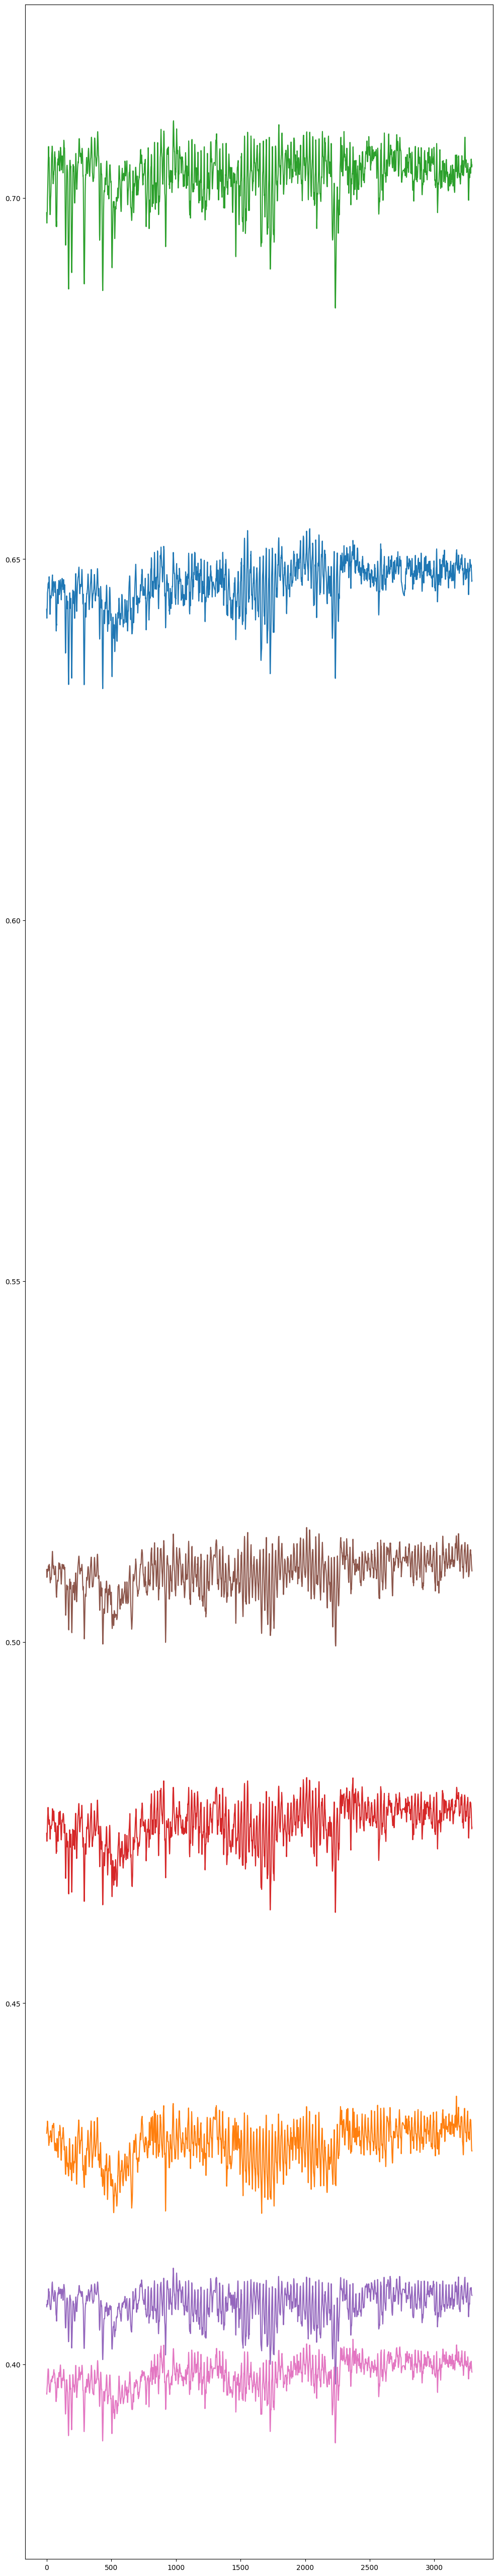

In [66]:
plt.figure(figsize=(12, 66))  # 设置图形宽度为更宽的大小
plt.plot(prd)
# plt.plot(hufl_t, color = 'blue', label = 'test')
plt.show()